# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import RobustScaler, OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score


In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [3]:
# Separate features and target variable
X = fires_dt.drop(columns=['area'])  # Drop the target variable from features
y = fires_dt['area']  # Define the target variable

In [4]:
# Display the first few rows of X and y
print("Features (X):")
print(X.head())
print("\nTarget (y):")
print(y.head())

Features (X):
   coord_x  coord_y month  day  ffmc   dmc     dc  isi  temp  rh  wind  rain
0        7        5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0
1        7        4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0
2        7        4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0
3        8        6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2
4        8        6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0

Target (y):
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: area, dtype: float64


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [5]:
# Define the feature columns
numeric_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_features = ['month', 'day']

# Create the preprocessing for preproc1
preproc1 = ColumnTransformer(
    transformers=[
        ('numeric', MinMaxScaler(), numeric_features),  # MinMaxScaler numeric features
        ('categoric', OneHotEncoder(handle_unknown='infrequent_if_exist'), categorical_features)  # One-hot encode categorical features
    ]
)

# Create a full pipeline with preprocessor and a model
pipe_simple = Pipeline([
    ('preprocess', preproc1)
])
pipe_simple

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categoric',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])]))])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [6]:
# Define numeric and categorical features
numeric_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_features = ['month', 'day']

# Specify columns for different transformations
other_numerical_columns = ['coord_x', 'coord_y', 'temp', 'wind']  # Example columns for MinMax scaling
transformed_columns = ['ffmc', 'dmc', 'dc', 'isi', 'rh', 'rain']  # Example columns for PowerTransform

# Create the preproc2 pipeline
preproc2 = ColumnTransformer(
    transformers=[
        ('num_var', MinMaxScaler(), other_numerical_columns), # Apply MinMax Scaling to other numerical columns transformation
        ('num_transform', PowerTransformer(), transformed_columns),  # Apply PowerTransform tp selected columns
        ('cat', OneHotEncoder(handle_unknown="infrequent_if_exist"), categorical_features)  # One-hot encode categorical features
    ]
)

# Create a full pipeline with preprocessor and a model
pipe_simple = Pipeline([
    ('preprocess', preproc2)
])
pipe_simple

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_var', MinMaxScaler(),
                                                  ['coord_x', 'coord_y', 'temp',
                                                   'wind']),
                                                 ('num_transform',
                                                  PowerTransformer(),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'rh', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])]))])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [11]:
# Pipeline A = preproc1 + baseline
# Define the baseline model (e.g., Linear Regression)
baseline_regressor = LinearRegression()

# Create Pipeline A: preproc1 + baseline
pipeline_A = Pipeline(steps=[
    ('preprocessing', preproc1),  # Use the preproc1 defined earlier
    ('regressor', baseline_regressor)  # Baseline regressor
])

# Display Pipeline A
pipe_simple = Pipeline([
    ('preprocess', preproc1)
])
pipe_simple

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categoric',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])]))])

In [12]:
# Pipeline B: preproc2 + Ridge Regression
pipeline_B = Pipeline(steps=[
    ('preprocessing', preproc2),  # Use the preproc2 defined earlier
    ('regressor', Ridge())  # Use Ridge as the baseline regressor
])

# Display Pipeline B
pipe_simple = Pipeline([
    ('preprocess', pipeline_B)
])
pipe_simple

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocessing',
                                  ColumnTransformer(transformers=[('num_var',
                                                                   MinMaxScaler(),
                                                                   ['coord_x',
                                                                    'coord_y',
                                                                    'temp',
                                                                    'wind']),
                                                                  ('num_transform',
                                                                   PowerTransformer(),
                                                                   ['ffmc',
                                                                    'dmc', 'dc',
                                                                    'isi', 'rh',
                                                                    'rain']),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                                   ['month',
                                                                    'day'])])),
                                 ('regressor', Ridge())]))])

In [13]:
# Pipeline C = preproc1 + advanced model
# Define the advanced model (e.g., Random Forest Regressor)
advanced_regressor = RandomForestRegressor()

# Create Pipeline C: preproc1 + advanced model
pipeline_C = Pipeline(steps=[
    ('preprocessing', preproc1),  # Use the preproc1 defined earlier
    ('regressor', advanced_regressor)  # Advanced regressor
])

# Display Pipeline C
pipe_simple = Pipeline([
    ('preprocess', pipeline_C)
])
pipe_simple

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocessing',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   MinMaxScaler(),
                                                                   ['coord_x',
                                                                    'coord_y',
                                                                    'ffmc',
                                                                    'dmc', 'dc',
                                                                    'isi',
                                                                    'temp',
                                                                    'rh',
                                                                    'wind',
                                                                    'rain']),
                                                                  ('categoric',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                                   ['month',
                                                                    'day'])])),
                                 ('regressor', RandomForestRegressor())]))])

In [14]:
# Create Pipeline D: preproc2 + advanced model
pipeline_D = Pipeline(steps=[
    ('preprocessing', preproc2),  # Use the preproc2 defined earlier
    ('regressor', advanced_regressor)  # Advanced regressor
])

# Display Pipeline D
pipe_simple = Pipeline([
    ('preprocess', pipeline_D)
])
pipe_simple

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocessing',
                                  ColumnTransformer(transformers=[('num_var',
                                                                   MinMaxScaler(),
                                                                   ['coord_x',
                                                                    'coord_y',
                                                                    'temp',
                                                                    'wind']),
                                                                  ('num_transform',
                                                                   PowerTransformer(),
                                                                   ['ffmc',
                                                                    'dmc', 'dc',
                                                                    'isi', 'rh',
                                                                    'rain']),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                                   ['month',
                                                                    'day'])])),
                                 ('regressor', RandomForestRegressor())]))])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [15]:
# Define the target variable
y = fires_dt['area']  # Assuming 'area' is your target variable
X = fires_dt.drop(columns=['area'])  # Features excluding target


In [16]:
# Adjusting the categorical transformer
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Pipeline A: preproc1 + Ridge Regression
pipeline_A = Pipeline(steps=[
    ('preprocessing', preproc1),  # Use the preproc1 defined earlier
    ('regressor', Ridge())  # Use Ridge as the baseline regressor
])

# Pipeline A: Grid Search for Ridge Regression
param_grid_A = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0]  # Regularization strengths for Ridge
}
grid_search_A = GridSearchCV(pipeline_A, param_grid=param_grid_A, cv=5, scoring='neg_mean_squared_error')
grid_search_A.fit(X, y)

# Results for Pipeline A
print("Best parameters for Pipeline A:", grid_search_A.best_params_)
print("Best score for Pipeline A:", grid_search_A.best_score_)

Best parameters for Pipeline A: {'regressor__alpha': 100.0}
Best score for Pipeline A: -4182.6213993817455


In [17]:
# Pipeline B: preproc2 + Ridge Regression
pipeline_B = Pipeline(steps=[
    ('preprocessing', preproc2),  # Use the preproc2 defined earlier
    ('regressor', Ridge())  # Use Ridge as the baseline regressor
])

# Pipeline B: Grid Search for Ridge Regression
param_grid_B = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0]  # Regularization strengths for Ridge
}
grid_search_B = GridSearchCV(pipeline_B, param_grid=param_grid_B, cv=5, scoring='neg_mean_squared_error')
grid_search_B.fit(X, y)

# Results for Pipeline B
print("Best parameters for Pipeline B:", grid_search_B.best_params_)
print("Best score for Pipeline B:", grid_search_B.best_score_)

Best parameters for Pipeline B: {'regressor__alpha': 100.0}
Best score for Pipeline B: -4172.777562401556


In [20]:
# Define Pipeline C: preproc1 + RandomForestRegressor
pipeline_C = Pipeline(steps=[
    ('preprocessing', preproc1),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Grid Search for Pipeline C
param_grid_C = {
    'regressor__n_estimators': [50, 100, 150, 200],  # Number of trees
    'regressor__max_depth': [None, 10, 20, 30]  # Maximum depth of trees
}
grid_search_C = GridSearchCV(pipeline_C, param_grid=param_grid_C, cv=5, scoring='neg_mean_squared_error')
grid_search_C.fit(X, y)

print("Best parameters for Pipeline C:", grid_search_C.best_params_)
print("Best score for Pipeline C:", grid_search_C.best_score_)

Best parameters for Pipeline C: {'regressor__max_depth': 10, 'regressor__n_estimators': 200}
Best score for Pipeline C: -4764.246704921435


In [21]:
# Pipeline D: preproc2 + RandomForestRegressor
pipeline_D = Pipeline(steps=[
    ('preprocessing', preproc2),  # Use preproc2
    ('regressor', RandomForestRegressor(random_state=42))  # Advanced model
])

# Pipeline D: Grid Search for RandomForestRegressor
param_grid_D = {
    'regressor__n_estimators': [50, 100, 150, 200],  # Number of trees
    'regressor__max_depth': [None, 10, 20, 30]  # Maximum depth of trees
}
grid_search_D = GridSearchCV(pipeline_D, param_grid=param_grid_D, cv=5, scoring='neg_mean_squared_error')
grid_search_D.fit(X, y)

# Results for Pipeline D
print("Best parameters for Pipeline D:", grid_search_D.best_params_)
print("Best score for Pipeline D:", grid_search_D.best_score_)

Best parameters for Pipeline D: {'regressor__max_depth': None, 'regressor__n_estimators': 200}
Best score for Pipeline D: -4753.62445635243


# Evaluate

+ Which model has the best performance?

In [22]:
# Collect the best scores from each pipeline
best_scores = {
    'Pipeline A': grid_search_A.best_score_,
    'Pipeline B': grid_search_B.best_score_,
    'Pipeline C': grid_search_C.best_score_,
    'Pipeline D': grid_search_D.best_score_
}

# Print out the best score for each pipeline
for pipeline, score in best_scores.items():
    print(f"{pipeline} Best Score (neg_mean_squared_error): {score}")

# Determine the pipeline with the highest score (least negative mean squared error)
best_pipeline = min(best_scores, key=best_scores.get)  # since scores are negative for error metrics
print(f"The best-performing pipeline is {best_pipeline} with a score of {best_scores[best_pipeline]}")

Pipeline A Best Score (neg_mean_squared_error): -4182.6213993817455
Pipeline B Best Score (neg_mean_squared_error): -4172.777562401556
Pipeline C Best Score (neg_mean_squared_error): -4764.246704921435
Pipeline D Best Score (neg_mean_squared_error): -4753.62445635243
The best-performing pipeline is Pipeline C with a score of -4764.246704921435


# Export

+ Save the best performing model to a pickle file.

In [23]:
import pickle

# Dictionary of GridSearchCV objects for each pipeline
grid_search_dict = {
    'Pipeline A': grid_search_A,
    'Pipeline B': grid_search_B,
    'Pipeline C': grid_search_C,
    'Pipeline D': grid_search_D
}

# Find the best-performing pipeline based on scores
best_pipeline_name = min(best_scores, key=best_scores.get)  # Best-performing pipeline name
best_grid_search = grid_search_dict[best_pipeline_name]  # Corresponding GridSearchCV object

# Save the best model from the GridSearchCV object
with open("best_model.pkl", "wb") as file:
    pickle.dump(best_grid_search.best_estimator_, file)

print(f"The best-performing model ({best_pipeline_name}) has been saved to 'best_model.pkl'")

The best-performing model (Pipeline C) has been saved to 'best_model.pkl'


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

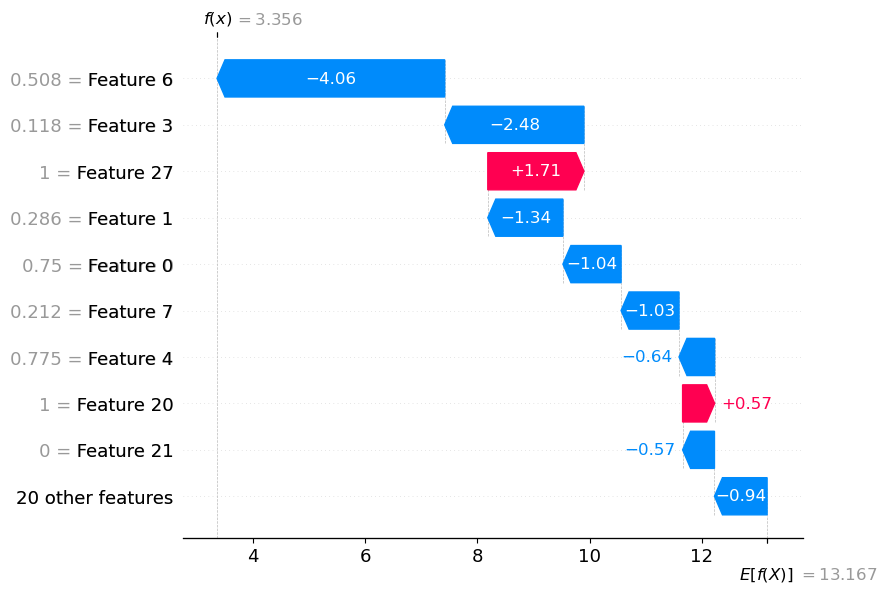

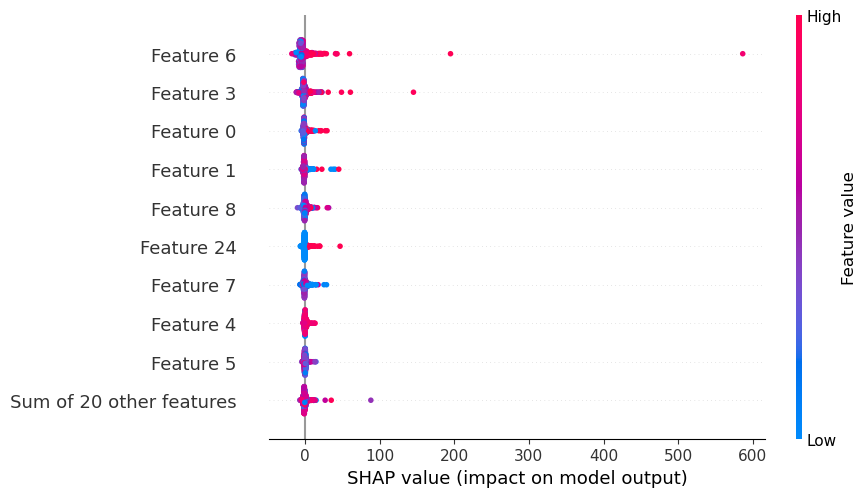

In [34]:
import shap
import shap.explainers

data_transform=best_model.named_steps['preprocessing'].transform(X)

best_model = grid_search_C.best_estimator_

best_model_only = best_model.named_steps['regressor']

feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()

df=pd.DataFrame(data_transform, columns=feature_names)

explainer = shap.TreeExplainer(best_model_only)

shap_values=explainer(data_transform)

shap.plots.waterfall(shap_values[1])
shap.plots.beeswarm(shap_values)

In [40]:
import shap
import pandas as pd
import numpy as np

# Fit the preprocessing only on training data
preprocessor = best_model.named_steps['preprocessing']
X_train_transformed = preprocessor.fit_transform(X_train)

# Get the best model
best_model_only = best_model.named_steps['regressor']

# Create the SHAP explainer
explainer = shap.TreeExplainer(best_model_only)

# Calculate SHAP values for the training set
shap_values_train = explainer.shap_values(X_train_transformed)

# Check the shape of SHAP values
print("Shape of SHAP values:", shap_values_train.shape)


Shape of SHAP values: (413, 29)


In [41]:
# Check if shap_values_train is a list (for multi-output models)
if isinstance(shap_values_train, list):
    shap_values_train = shap_values_train[0]  # Take the first output for simplicity

# Create a DataFrame to hold the mean absolute SHAP values
mean_abs_shap = pd.DataFrame({
    'feature': preprocessor.get_feature_names_out(),  # Use feature names from the preprocessor
    'mean_shap': np.abs(shap_values_train).mean(axis=0)
})

# Sort by importance
mean_abs_shap = mean_abs_shap.sort_values(by='mean_shap', ascending=False)

# Most and least important features
most_important_features = mean_abs_shap.head(10)
least_important_features = mean_abs_shap.tail(10)

print("Most Important Features:\n", most_important_features)
print("Least Important Features:\n", least_important_features)


Most Important Features:
                feature  mean_shap
6        numeric__temp   6.363976
3         numeric__dmc   3.698429
0     numeric__coord_x   2.108189
24  categoric__day_sat   2.086496
7          numeric__rh   2.067592
1     numeric__coord_y   1.979015
5         numeric__isi   1.836954
8        numeric__wind   1.506791
4          numeric__dc   1.088532
2        numeric__ffmc   1.003062
Least Important Features:
                  feature  mean_shap
20  categoric__month_oct   0.075650
18  categoric__month_may   0.068864
13  categoric__month_feb   0.058991
12  categoric__month_dec   0.044238
17  categoric__month_mar   0.042093
10  categoric__month_apr   0.029481
16  categoric__month_jun   0.013359
9          numeric__rain   0.002425
14  categoric__month_jan   0.000108
19  categoric__month_nov   0.000000


If I were to remove features, I would first look at the SHAP values’ global feature importance (e.g., from the beeswarm plot). Features with low SHAP values across the dataset contribute minimally to predictions, indicating they might be redundant or add noise. Removing these features could simplify the model and potentially improve its performance. I would prioritize removing features based on the following criteria:

- Low SHAP Value: Features consistently showing low SHAP values across observations are less influential in predictions.
- High Correlation with Other Features: If a feature is highly correlated with another, it may be redundant. Removing one from each correlated pair can reduce multicollinearity, simplifying the model.
- Domain Knowledge: Certain features may be irrelevant to the target outcome, or too difficult to quantify accurately. For instance, if workclass is inconsistent or lacks predictive power, it might be a candidate for removal.

To verify if these features enhance model performance, I would use an iterative feature removal process:

- Retrain and Compare: Remove the selected features, retrain the model, and evaluate its performance on a holdout validation set. Comparing metrics like RMSE, R², or mean absolute error (MAE) before and after feature removal will indicate if the changes positively impact performance.

- Cross-Validation: Perform cross-validation with and without the removed features to ensure changes are robust and not due to randomness in a single train-test split.

- Statistical Testing: For formal evaluation, a hypothesis test (e.g., McNemar’s test) could determine if the performance difference is statistically significant.

- SHAP Analysis on Reduced Model: Re-calculate SHAP values for the reduced model to check if the overall interpretability improves, with fewer low-impact features. This step ensures that the simplified model still captures the most important patterns in the data effectively.

Through this process, we can confirm whether each feature genuinely contributes to the model's accuracy or if removing it enhances both simplicity and performance.

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.